In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
import MetaTrader5 as mt5
import time
import os

from dotenv import load_dotenv

import pandas as pd

load_dotenv()

# Set the path and login details for MT5
path = r"C:\Program Files\Vantage International MT5\terminal64.exe"
server = 'VantageInternational-Demo'
mt5_username = os.getenv('mt5_vantage_demo_username')
password = os.getenv('mt5_vantage_demo_password')

# server = 'VantageInternational-Live'
# mt5_username = os.getenv('mt5_vantage_live_username')
# password = os.getenv('mt5_vantage_live_password')

# Trading parameters
deviation = 20
symbol = 'BTCUSD'
yf_symbol = 'BTC-USD'
lot_size = 0.1
sl_pips = 20000
tp_pips = 20000
check_interval = 60 * 5 *12

# Initialize MT5 connection
def start_mt5():
    if not mt5.initialize(login=int(mt5_username), password=str(password), server=str(server), path=str(path)):
        print("initialize() failed, error code =", mt5.last_error())
        quit()
start_mt5()
# Ensure MT5 is started
print(mt5.terminal_info())




TerminalInfo(community_account=False, community_connection=False, connected=True, dlls_allowed=False, trade_allowed=True, tradeapi_disabled=False, email_enabled=False, ftp_enabled=False, notifications_enabled=False, mqid=True, build=4260, maxbars=100000, codepage=0, ping_last=215424, community_balance=0.0, retransmission=3.530027320349901, company='Vantage International Group Limited', name='Vantage International MT5', language='English', path='C:\\Program Files\\Vantage International MT5', data_path='C:\\Users\\admin\\AppData\\Roaming\\MetaQuotes\\Terminal\\AE2CC2E013FDE1E3CDF010AA51C60400', commondata_path='C:\\Users\\admin\\AppData\\Roaming\\MetaQuotes\\Terminal\\Common')


In [2]:
# Define parameters
symbol = "EURUSD"
timeframe = mt5.TIMEFRAME_H1  # Hourly data
n_points = 10000  # Number of data points to download

# Get historical data
rates = mt5.copy_rates_from_pos(symbol, timeframe, 0, n_points)

# Shut down MetaTrader 5 connection
mt5.shutdown()

# Convert to a pandas DataFrame
data = pd.DataFrame(rates)

# Convert time in seconds to the datetime format
data['time'] = pd.to_datetime(data['time'], unit='s')

In [3]:
# Check for missing values
if data.isnull().values.any():
    data = data.dropna()

# Reset index to be the time column
data.set_index('time', inplace=True)

In [4]:
# Calculate simple moving average as an example feature
data['SMA'] = data['close'].rolling(window=50).mean()

# Calculate the logarithmic return of the closing price
data['log_return'] = np.log(data['close'] / data['close'].shift(1))

In [5]:
from sklearn.preprocessing import MinMaxScaler

# Select features to use
features = ['close', 'SMA', 'log_return']
data = data[features].dropna()  # Drop rows with NaN values

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create X, y datasets
sequence_length = 60
X, y = [], []

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i - sequence_length:i])
    y.append(scaled_data[i, 0])  # Assuming you are predicting the close price

X = np.array(X)
y = np.array(y)

In [6]:
# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [7]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Assume 'data' is your DataFrame and you're predicting the closing price
dataset = data['close'].values
dataset = dataset.reshape(-1, 1)

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# Create a dataset where X is the number of past time steps you want to use to predict the future
# and y is the value at the future time step you want to predict
sequence_length = 60  # number of past time steps to use to predict the future

X = []
y = []

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i, 0])
    y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)

# Split into train and test datasets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape data to fit the LSTM layer input requirements [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [8]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# Initialize the RNN
model = Sequential()

# Adding the first LSTM layer and some Dropout regularization
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularization
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

# Adding a third LSTM layer
model.add(LSTM(units=50))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units=1))

# Compiling the RNN
model.compile(optimizer='adam', loss='mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs=10, batch_size=32)

c:\Users\admin\VSC\forexComplex\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 23s 65ms/step - loss: 0.0433
Epoch 2/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 17s 66ms/step - loss: 0.0038
Epoch 3/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 17s 67ms/step - loss: 0.0033
Epoch 4/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 17s 68ms/step - loss: 0.0031
Epoch 5/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 17s 68ms/step - loss: 0.0026
Epoch 6/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 17s 67ms/step - loss: 0.0024
Epoch 7/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 16s 66ms/step - loss: 0.0024
Epoch 8/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 21s 66ms/step - loss: 0.0021
Epoch 9/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 20s 64ms/step - loss: 0.0020
Epoch 10/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 17s 68ms/step - loss: 0.0018


In [9]:
model.save('forex_prediction_model.keras')

62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step


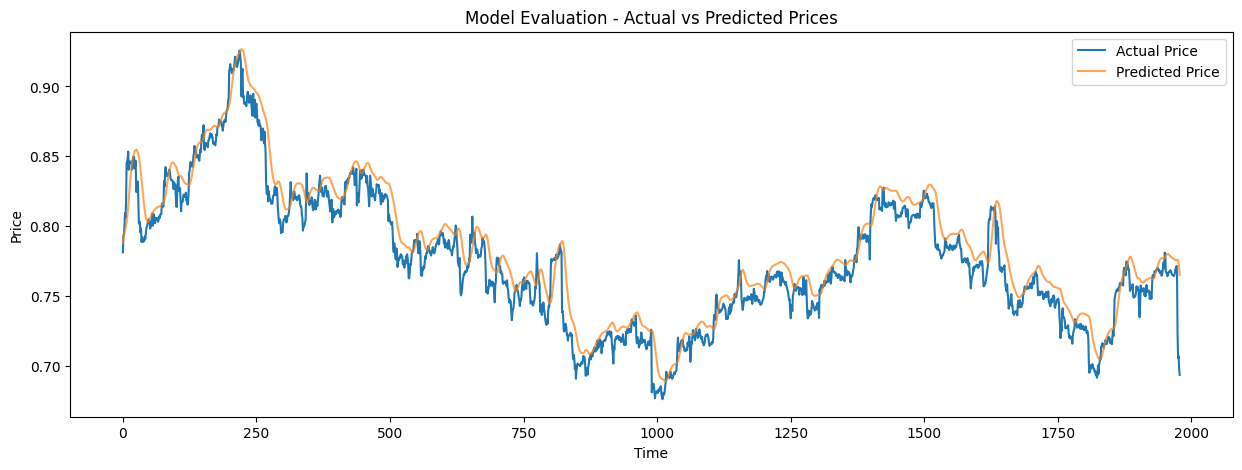

Mean Squared Error: 0.0002240001176856687
R^2 Score: 0.9012902875075725
Action: BUY
Entry Price: 0.6933147146098806
SL Price: 0.6794484203176829
TP Price: 0.7210473031942758


In [12]:
# Import necessary libraries
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Assuming 'model' is your trained model and 'X_test', 'y_test' is your test dataset
predicted_prices = model.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, predicted_prices)
r2 = r2_score(y_test, predicted_prices)

# Visualize the predicted vs actual prices
plt.figure(figsize=(15, 5))
plt.plot(y_test, label='Actual Price')
plt.plot(predicted_prices, label='Predicted Price', alpha=0.7)
plt.title('Model Evaluation - Actual vs Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# Print out the performance metrics
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

# Now, let's assume that 'predicted_prices' are the predictions for the next period
# We need to define the trading strategy parameters:
threshold_percentage = 0.01
stop_loss_percentage = 0.02
take_profit_percentage = 0.04

# Assuming the last value of 'y_test' is the last known price
current_market_price = y_test[-1]

# Function to calculate SL and TP based on the entry price
def calculate_sl_tp(entry_price, sl_pct, tp_pct, action):
    sl_price = entry_price * (1 - sl_pct) if action == 'BUY' else entry_price * (1 + sl_pct)
    tp_price = entry_price * (1 + tp_pct) if action == 'BUY' else entry_price * (1 - tp_pct)
    return sl_price, tp_price

# Function to generate trading signal based on the prediction
def generate_signal(predicted_price, current_price, threshold_perc, sl_perc, tp_perc):
    if predicted_price > current_price * (1 + threshold_perc):
        action = 'BUY'
        entry_price = current_price
        sl_price, tp_price = calculate_sl_tp(entry_price, sl_perc, tp_perc, action)
    elif predicted_price < current_price * (1 - threshold_perc):
        action = 'SELL'
        entry_price = current_price
        sl_price, tp_price = calculate_sl_tp(entry_price, sl_perc, tp_perc, action)
    else:
        action = 'HOLD'
        entry_price = sl_price = tp_price = None
    return action, entry_price, sl_price, tp_price

# Now let's assume we're only looking at the latest prediction for the next trade signal
latest_prediction = predicted_prices[-1]
action, entry_price, sl_price, tp_price = generate_signal(
    latest_prediction,
    current_market_price,
    threshold_percentage,
    stop_loss_percentage,
    take_profit_percentage
)

# Output the trade signal
if action != 'HOLD':
    print(f"Action: {action}")
    print(f"Entry Price: {entry_price}")
    print(f"SL Price: {sl_price}")
    print(f"TP Price: {tp_price}")
else:
    print("No trade signal generated. HOLD.")